# Importações Principais

In [123]:
import pandas as pd 
import numpy as np
import seaborn as sns
import re
import string
import nltk
from string import digits
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
#from sklearn.naive_bayes import MultinomialNB  Possível modelo para análise futura
from sklearn.feature_extraction.text import TfidfVectorizer 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support

# Leitura do dataset

In [7]:
dados_treino = pd.read_csv('train.csv')
dados_teste = pd.read_csv('test.csv')
dados_label =pd.read_csv("test_labels.csv")

In [97]:
x_treino = dados_treino['comment_text']
y_treino= dados_treino[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]

x_teste =  dados_teste['comment_text']
y_teste= dados_label[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]

O código a seguir é responsável por processar todas as palavras do texto (após certo tratamento), classificá-las em substantivo, verbo, adjetivo e adverbio para que em seguida a função `Lemmatizer`consigua adequadamente transformar cada palavra em sua forma base. Essa pré classificação é importante pois um dos argumentos principais da função lemmatizer é o tipo de palavra que se deseja passar para a forma base.

Apesar de ser um algoritimo que garante uma boa acurácia na hora de transformar as palavras em sua forma base, ele exige um alto poder de processamento o que acaba tornando o processo bem lento na maioria dos computadores. Dessa forma, como iteração futura pretendemos analisar o quão necessário é adoção dele em nosso código, comparando a acurácia na previsão com e sem ele.

# Pré-processamento

In [4]:
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words("english"))
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]

Como uma primeira análise optamos por averiguar apenas a influência de palavras no tipo de comentário no qual elas se inserem. Mais adiante, pretendemos aplicar o chamado 'feature engineering' para compreender correlações entre pontuações, letras maisculas, tamanho da sentença, dentro outros com a toxicidade do comentário.

In [9]:
def limpeza(text):
    
    text = text.encode('ascii', errors = 'ignore').decode() #Decodificando caracteres em ASCII
    text = text.lower() #Apenas caracteres minúsculos
    text = re.sub(r'http\S+', ' ', text) #Evitando links
    #Evitando contrações
    text = re.sub(r'#+', ' ', text) #removendo hashtags
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #removendo menções
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text) #substituindo 's por i
    text = re.sub(r"what's", "what is ", text) 
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"won't", "will not ", text) 
    text = re.sub(r"\'ve", " have ", text) 
    text = re.sub(r"can't", "can not ", text) 
    text = re.sub(r"n't", " not ", text) 
    text = re.sub(r"isn't", "is not ", text) 
    text = re.sub(r"i'm", "i am ", text) 
    text = re.sub(r"\'re", " are ", text) 
    text = re.sub(r"\'d", " would ", text) 
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text) #remove qualquer caracter não alfanumérico
    text = re.sub('\s+', ' ', text) # remove espaçamentos do tipo \r\n\t\f\v 
    text = re.sub(r'\d+', ' ', text) #remove digitos
    text = text.strip(' ') #Removendo espaços do começo e fim 
    #text = lemmatize_words(text)
    
    return text


# Substituindo textos do DataFrame pelos texto tratados no pré-processamento

In [10]:
#tqdm é a barra de progresso, últil, visto que o processo de limpeza com a lemmatização é longo
from tqdm.notebook import tqdm

tqdm.pandas(desc='Limpando o texto')
dados_treino['comment_text'] = dados_treino['comment_text'].progress_apply(limpeza)

C:\Users\Jean Silas\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
tqdm.pandas(desc='Limpando o texto')
dados_teste['comment_text'] = dados_teste['comment_text'].progress_apply(limpeza)

In [12]:
x_teste = dados_teste['comment_text']

# Train Test Split

## Importações específicas

In [14]:
#! pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Tokenização

A **primeira** parte do processo de separação de nossos dados em treino e teste consiste na chamada Tokerização. 
A tokenização de um modo bem simples é um processo que atribui a cada palavra diferente de nosso corpus textual um índice que facilitá a manipulação delas. A palavra deixará de ser um conjunto de letras para ser simplismente um número.
Um vídeo bem didático, do qual baseia-se essa parte do códico é o seguinte:

https://www.youtube.com/watch?v=fNxaJsNG3-s&t=31s

In [15]:
tokenizer = Tokenizer(oov_token="<OOV>")

O parâmetro `oov_token` serva basicamente para que mais adiante sejam computadas palavras que não estavam no nosso vocabulário. Elas apareceram com a key `<OOV>`. Isso garante que a sequências terão o mesmo tamanho da frase, o que facilita processos posteriores. `fit_on_text`


In [16]:
x_treino = dados_treino["comment_text"]

In [17]:
tokenizer.fit_on_texts(x_treino)
word_index = tokenizer.word_index

O resultado é um dicionário onde as palavras são as `keys` e o indíces são os `values`
Aqui vai um exemplo de como fica palavras e seus respesctivos indices:

In [18]:
for key in sorted(word_index)[10000:10010]:
    print (key, word_index[key])

asuna 56346
asunder 60965
asure 116079
asurle 160302
asus 49167
asutralian 111946
asutrian 152817
aswad 76942
aswell 8716
aswer 93324


## Sequenciando

Os tweets podem ser compostos por mais de uma palavras, se cada palavra é representada por um número vamos agora criar uma sequência de números para cada tweet. O conceito de sequências pode ser melhor compreendido em :
https://www.youtube.com/watch?v=r9QjkdSJZ2g&t=4s

In [19]:
sequencias = tokenizer.texts_to_sequences(x_treino)

Certamenta temos sequências de diferentes tamanhos, uma vez que as frase possuem diferentes números de palavras. Para que todas possuam o mesmo tamanho usamos o chamado paddind que acrescenta zeros as sequências para que nesse caso fiquem com o mesmo tamanho da maior delas.

In [20]:
X = pad_sequences(sequencias, padding='post')
Y = y_treino.values

Para lidarmos com o split de um conjunto de dados multilabel, optou-se pelo uso da biblioteca Scikit-multilearn direcionada justamente para esse tipo de caso. 

## Interative_train_test_split

In [16]:
#! pip install scikit-multilearn

Geralmente em problemas do tipo, uma abordagem comum é a de dividir os dados em "folds", ou seja porções aleatórias de nossa amostra. Algumas folds viram dados de treino e o restante de teste. Entretanto essa abordagem não gera evidência suficiente para cada classe me cada fold graças ao desbalanceamento de classes presente na maioria dos problemas. Isso por sua vez gera um modelo enviesado e com limitações em suas previsões.


De modo a solucionar essas problemáticas optamos por outra abordagem: o conceito por trás do método de `interative_train_test_spli` é o de **"Estratificação"** que divide amostras do dataset em subsets que mantém uma proporção aproximadamente igual de elementos de cada classe em cada fold.

Lembrando que ja foi provado no artigo "A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection" de Ron Kohavi que o método de estratificação se mostra mais estável se comparado com métodos de cross validation.

Uma análise técnica e aprofundada do método pode ser encontrada no artigo 'A Network Perspective on Stratification of Multi-Label Data', por Piotr Szymański and Tomasz Kajdanowicz


In [17]:
from skmultilearn.model_selection import iterative_train_test_split
#Lembrando que a seed é um método de garantir que sempre que rodarmos a função, ela terá o mesmo random state e consequentemente nos dará o mesmo resultado
np.random.seed(42)
x_train_sp, y_train_sp, x_test_sp, y_test_sp = iterative_train_test_split(X, Y, test_size=0.2)

## Verificando o split

### Função de contagem de ocorrência de labels

Agora, vamos verificar se de fato o split foi feito de uma forma balanceada garantindo uma proporção semelhante de cada tipo de comentario nos dados de treino e nos dados de teste.

Vamos primeiro criar uma função que conta as ocorrências de cada label:

In [18]:
def count_occurrences_labels(df):

  CLASSES = {
    'toxic':         0,
    'severe_toxic':  0,
    'obscene':       0,
    'threat':        0,
    'insult':        0,
    'identity_hate': 0,

  }

  for vet in df.values:
    for value, label in zip(vet, CLASSES):
      CLASSES[label] += int(value)

  return CLASSES

Em seguida criamos uma lista para armazernar o nome dos nossos labels:

In [19]:
labels = list(dados_treino.iloc[:, 2:].columns.values)
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Função para calcular proporções de labels

Depois de fazer a contagem de quantas vez cada label aparece, precisamos determiar as proporções de cada um no conjunto de treino e no de teste para mais adiante verificarmos se elas são suficientemente próximas.

In [20]:
def calculates_labels_proportion(DICT_CLASSES, labels_names):

  proportions = {}

  for label in labels_names:
    prop = DICT_CLASSES[label]/sum(DICT_CLASSES.values())
    proportions.update({label: prop})
    
  df = pd.DataFrame([proportions])

  return df

### Ocorrência de labels em todo o data-set:

In [21]:
classif_data = count_occurrences_labels(dados_treino[labels])
classif_data

{'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

### Ocorrência de labels no subset de treino

In [22]:
classif_train = count_occurrences_labels(pd.DataFrame(y_train_sp))
classif_train

{'toxic': 12235,
 'severe_toxic': 1276,
 'obscene': 6759,
 'threat': 382,
 'insult': 6302,
 'identity_hate': 1124}

### Ocorrência de labels no subset de teste

In [23]:

classif_test = count_occurrences_labels(pd.DataFrame(y_test_sp))

classif_test

{'toxic': 3059,
 'severe_toxic': 319,
 'obscene': 1690,
 'threat': 96,
 'insult': 1575,
 'identity_hate': 281}

### Análise final com proporções

In [24]:
prop_data = calculates_labels_proportion(classif_data, labels)
prop_train = calculates_labels_proportion(classif_train, labels)
prop_test = calculates_labels_proportion(classif_test, labels)

result_prop = pd.concat([prop_data, prop_train, prop_test], ignore_index=True)
result_prop.rename(index={
    0: 'dataset', 
    1: 'train_set', 
    2: 'test_set'}, inplace=True)

result_prop


,toxic,severe_toxic,obscene,threat,insult,identity_hate
dataset,0.435751,0.045444,0.240726,0.013619,0.224429,0.040031
train_set,0.435750,0.045445,0.240722,0.013605,0.224446,0.040031
test_set,0.435755,0.045442,0.240741,0.013675,0.224359,0.040028


# WordCloud para vizualização das palavras mais frequentes em cada tipo de comentário após o pré-processamento

In [ ]:


#wordcloud para comentários tóxicos
subset=dados_treino[dados_treino.toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.figure(figsize = (50,50))
plt.subplot(321)
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Tóxicos ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários severamente tóxicos
plt.subplot(322)
subset=dados_treino[dados_treino.severe_toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Severamente Tóxicos ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários obscenos
plt.subplot(323)
subset=dados_treino[dados_treino.obscene==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Obscenos ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários de ameaça
plt.subplot(324)
subset=dados_treino[dados_treino.threat==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Ameaça ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")


#wordcloud para comentários de insulto
plt.subplot(325)
subset=dados_treino[dados_treino.insult==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Insulto ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")



#wordcloud para comentários de Preconceito
plt.subplot(326)
subset=dados_treino[dados_treino.identity_hate==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Preconceito ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")





# Vetorizando nossos textos tratados

Após um breve pesquisa, concluímos que no problema com o qual estamos lidando o método de vetorização disponível pela biblioteca Sklearn mais adequado é o `TfidfVectorizer`

TF_IDF significa em tradução livre : Frequência do termo - Inverso da Frequência no Documento. Seu objetivo é definir o quão importante uma palavra é pro documento, enquanto leva em consideração sua relação com outros documentos de nosso corpus textual.

A lógica por tráz da classificação desse algorítmo é a seguinte:
Uma Palavra que aparece frequentemente em um documento possui mais relevância para esse documento, o que quer dizer que ele tem uma alta probabilidade de se tratar dessa palavra ou de algo sobre ela. Já uma palavra que aparece frequentemente em mais de um documento pode nos atrapalhar em achar o documento que desejamos no meio de vários; Por exemplo, se a palavra 'fuck' está na grande maioria dos comentários, ela acaba não sendo tão relevante na classificação desse comentário, uma palavra mais específica como 'nigger', teria um impacto maior na classificação, uma vez que ela é menos frequente e ao vermos ela temos quase que certeza absoluta que se trata de um comentário, por exemplo de preconceito.

O algorítmo atribui uma certa nota a cada palavra. Essa nota aumenta com cada aparição sua no documento, entretanto diminui com cada apariçnao sua em outros documentos


Texto inspirado em: https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

In [21]:
#Antes de vetorizar os dados de treino e de teste, devemos criar um vocabulário universal.
# Para isso concatenaremos os dados de treino e teste.
x_tudo = pd.concat([x_teste, x_treino])
x_tudo.index = range(len(x_tudo))
cv = TfidfVectorizer(stop_words='english')
cv.fit(x_tudo)
x_tudo

0         yo bitch ja rule is more succesful then you wi...
1                   from rfc the title is fine as it is imo
2                            sources zawe ashton on lapland
3         if you have a look back at the source the info...
4                 i do not anonymously edit articles at all
                                ...                        
312730    and for the second time of asking when your vi...
312731    you should be ashamed of yourself that is a ho...
312732    spitzer umm theres no actual article for prost...
312733    and it looks like it was actually you who put ...
312734    and i really do not think you understand i cam...
Name: comment_text, Length: 312735, dtype: object

In [22]:
x_treinocv = cv.transform(x_treino)
x_testecv = cv.transform(x_teste)

In [27]:

#Para uma análise futura
#model_mnvb = MultinomialNB()
#model_mnvb.fit(x_treinocv,y_train.toxic.head(10))
#dados.loc[dados.toxic!=0,:]

# Aplicando modelo de predição junto com a acurácia obtida

Para uma primeira análise estamos um método conhecido como "Relevância Binária", ele basicamente trata cada 'Label' ou tipo de comentário como um problema separado de classificação, ou seja, a priório não estamos analisando nenhuma correlação entre os diversos labels, que por sinal existem. Tal análise virá em iterações futuras.

In [98]:
#Aqui foi criado um novo data frame de testem já que havia a ocorrência de -1';
# Como não sabemos se um erro ou se é intencional criamos um novo dataframe mas não alteramos o antigo;
# a alteração feita troca os -1's por 1.
y_teste1 = y_teste.replace(-1,1)

In [99]:
#Modelo: Regressão Logística
modelo_RL = LogisticRegression()
rotulos = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
resultados = dict()


In [117]:
for rotulo in rotulos:
    print('... Processando {}'.format(rotulo))
    y = y_treino[rotulo]
    yt = y_teste1[rotulo]
    modelo_RL.fit(x_treinocv, y)
    y_preve_X = modelo_RL.predict(x_treinocv)
    y_pred = modelo_RL.predict(x_testecv)
    resultados[rotulo] = np.array(y_pred)
    print('A acurácia do treino é {}'.format(accuracy_score(y, y_preve_X)))
    print("A acurácia do teste é de {}".format(accuracy_score(yt,y_pred)))

... Processando obscene
A acurácia do treino é 0.979231815304786
A acurácia do teste é de 0.468034263926249
... Processando insult
A acurácia do treino é 0.9726391386906142
A acurácia do teste é de 0.44789898409547935
... Processando toxic
A acurácia do treino é 0.9606444780066553
A acurácia do teste é de 0.5045506777049438
... Processando severe_toxic
A acurácia do treino é 0.99123274279161
A acurácia do teste é de 0.41986367553733256
... Processando identity_hate
A acurácia do treino é 0.9923168996872865
A acurácia do teste é de 0.4169582930714789
... Processando threat
A acurácia do treino é 0.9972300731335895
A acurácia do teste é de 0.41702358256509364


In [104]:
# Dataframe com os resultados do primeiro modelo, com approach binário, e não multi rotular.
dados_res = pd.DataFrame(resultados)
dados_res

,obscene,insult,toxic,severe_toxic,identity_hate,threat
0,1,1,1,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
153159,0,0,1,0,0,0
153160,0,0,0,0,0,0
153161,0,0,0,0,0,0
153162,0,0,0,0,0,0


# Visualizando os resultados a partir de uma Matriz Confusão

 A matriz confusão é um tipo de método/tabela de que nos permite uma melhor visualização dos resultados e, com isso o desempenho do modelo/algoritmo de classificação. Nesse tipo de tabela, existe 4 classificações importantes de serem pensadas que são os : Verdadeiro Negativo-*True Neg*-, Falso Positivo-*False Pos*-, Falso Negativo-*False Neg*- e Verdadeiro Positivo-*True Pos*-. A partir deles, nós podemos identificar a acurácia, os tipos de erro I e II e portanto a qualidade do modelo.

In [118]:
#Aqui é criado um dicionário para guardar obejto consusion_matriz de cada classe de comentário, já que o modelo teve um approach binário.
cm = dict()
for rotulo in rotulos:
    cm[rotulo]=confusion_matrix(y_teste1[rotulo], resultados[rotulo])

# Plotando as Matrizes Confusão para cada classe.

## Matriz confusão de Obscene

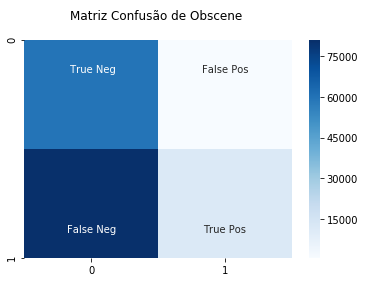

In [166]:
labels = ['\n \n \n \n \n True Neg','\n \n \n \n \nFalse Pos','False Neg\n \n \n \n \n','True Pos\n \n \n \n \n']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm['obscene'], annot=labels, fmt='', cmap='Blues')
plt.title("Matriz Confusão de Obscene \n ")
plt.show()

## Matriz Confusão de Insult

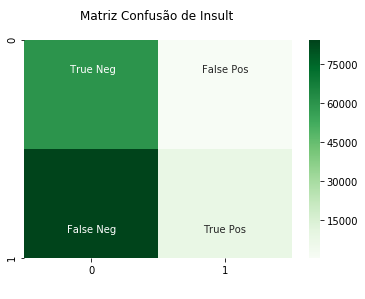

In [167]:
labels = ['\n \n \n \n \n True Neg','\n \n \n \n \nFalse Pos','False Neg\n \n \n \n \n','True Pos\n \n \n \n \n']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm['insult'], annot=labels, fmt='', cmap='Greens')
plt.title("Matriz Confusão de Insult \n ")
plt.show()

## Matriz Confusão de Toxic

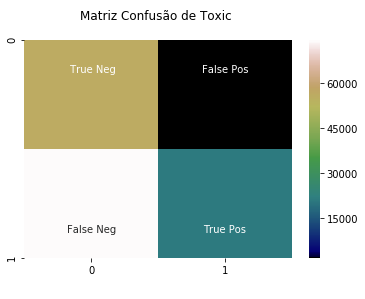

In [168]:
labels = ['\n \n \n \n \n True Neg','\n \n \n \n \nFalse Pos','False Neg\n \n \n \n \n','True Pos\n \n \n \n \n']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm['toxic'], annot=labels, fmt='', cmap='gist_earth')
plt.title("Matriz Confusão de Toxic \n ")
plt.show()

## Matriz Confusão de Severe Toxic

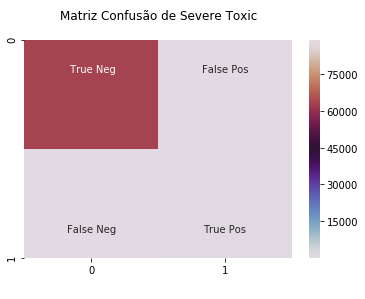

In [169]:
labels = ['\n \n \n \n \n True Neg','\n \n \n \n \nFalse Pos','False Neg\n \n \n \n \n','True Pos\n \n \n \n \n']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm['severe_toxic'], annot=labels, fmt='', cmap='twilight')
plt.title("Matriz Confusão de Severe Toxic\n ")
plt.show()

## Matriz Confusão de Identity Hate

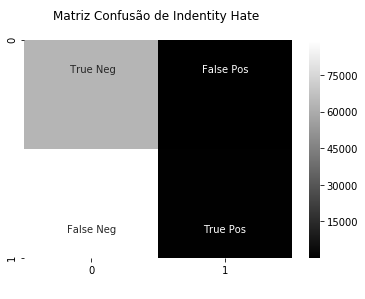

In [170]:
labels = ['\n \n \n \n \n True Neg','\n \n \n \n \nFalse Pos','False Neg\n \n \n \n \n','True Pos\n \n \n \n \n']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm['identity_hate'], annot=labels, fmt='', cmap='gist_gray')
plt.title("Matriz Confusão de Indentity Hate \n ")
plt.show()

## Matriz Confusão de Threat

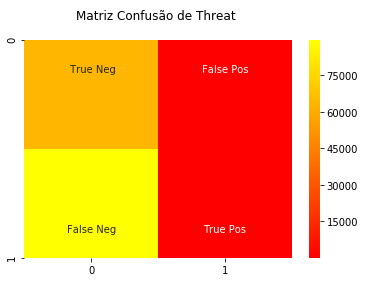

In [171]:
labels = ['\n \n \n \n \n True Neg','\n \n \n \n \nFalse Pos','False Neg\n \n \n \n \n','True Pos\n \n \n \n \n']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm['threat'], annot=labels, fmt='', cmap='autumn')
plt.title("Matriz Confusão de Threat \n ")
plt.show()

# Tentativa de Tuning do Modelo a partir de RandomizedSearchCV

Randomized Search é um método de melhoramento do modelo a partir de cross-validation e hiperparâmetros. Com ele podemos escolher o número de interações que usaremos, para assim podermos utilizar somente o poder computacional disponível.

Aqui está um video que trás a explicação e implementação dele de modo pedagógico : https://www.youtube.com/watch?v=Gol_qOgRqfA

In [2]:
# pra começar o Random Search, importamos a biblioteca:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# Criamos um dicionário cujas chave são as instâncias do nosso modelo e os valores são os diferentes possibilidade de parametro.
# Criamos também uma obejto do tipo Regressão Logística
C = list(np.arange(1,15,1))
penalty = ['l1','l2']
dual = ['False','True']
fit_intercept = ['True','False']
param_grid = dict(C = C,penalty=penalty,fit_intercept=fit_intercept)
LG = LogisticRegression()

In [1]:
# Criamos o obejto de Randomized Search e um dicionário que guardará os objetos para cada classe.
rand = RandomizedSearchCV(LG, param_grid, cv=10, scoring='accuracy', n_iter=1, random_state=5)
rand_dict = dict()

NameError: name 'RandomizedSearchCV' is not defined

In [ ]:
#Criamos um dicionario que as chaves são as classes e os valores são: o objeto de Rand, a acurácia e o f1_score
for rotulo in rotulos:
    r = rand.fit(x_treinocv,y_treino[rotulo])
    rand_dict[rotulo] = [r,accuracy_score(y_teste[rotulo],rand.predict(x_testecv)),f1_score(y_teste[rotulo],rand.predict(x_testecv))

C:\Users\Jean Silas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jean Silas\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
